In [180]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from hmmlearn.hmm import GaussianHMM
import seaborn as sns
import plotly.graph_objects as go

In [216]:
class Portfolio:
  def __init__(self, portfolio:list,  lower_bound:float, upper_bound:float):
    try:
      if lower_bound >= upper_bound:
        raise ValueError("Lower bound must be less than upper bound.")

      self.portfolio = portfolio
      self.lower_bound = lower_bound
      self.upper_bound = upper_bound
      self.portfolio_df = None
      self.weights = None
      self.normalized_df = None
      self.green_colors = None

    except Exception as e:
      print(f"Error in Portfolio intializer function: {e}")
      return None

  def get_data(self, period:str=None, start_date:str=None, end_date:str=None):
    """
    Returns a dataframe of the historical adjusted close prices of the assets.
    - Only one method of date input should be provided, either 'period' or 'start_date' and 'end_date'.
    - Length of time series should be large enough to handle metric calculations.

    Parameters:
    - period: yfinance time period (e.g., '3mo', '1y', '3y', '5y', 'ytd', 'max').
    - start_date: Start date of the time series. YYYY-MM-DD format.
    - end_date: End date of the time series. YYYY-MM-DD format.
    """
    try:
      if period and (start_date or end_date): #checks if both methods of date input are used
        raise ValueError("Provide either 'period' OR both 'start_date' and 'end_date' -- not both.")

      if period:
        period = period.strip()
        self.portfolio_df = yf.download(self.portfolio, period=period, progress=False, auto_adjust=False)["Adj Close"]
      elif start_date and end_date:
        start_date = start_date.strip()
        end_date = end_date.strip()
        self.portfolio_df = yf.download(self.portfolio, start=start_date, end=end_date, progress=False, auto_adjust=False)["Adj Close"]
      else:
        raise ValueError("You must provide either a 'period' or both 'start_date' and 'end_date'.")
      
      NaN_count = self.portfolio_df.isna().sum().sum()
      df_size = self.portfolio_df.size

      if self.portfolio_df.empty or self.portfolio_df is None:
        raise ValueError("Downloaded price data is empty or unavailable.")
      elif len(self.portfolio_df) <= 2:
        raise ValueError("Downloaded price data is too short.")
      elif len(self.portfolio_df) < 21: #average trading days in a month
        print("Warning: Limited price history may lead to unreliable metrics.")
        
      if NaN_count >= df_size//10:
        print("Warning: Some price data does not exist within the downloaded time period. Proceed with caution.")
      elif NaN_count == df_size:
        raise ValueError("All downloaded data is NaN. Check the ticker symbols and date range.")

      return self.portfolio_df

    except Exception as e:
      print(f"Error in get_data: {e}")
      return None
    

  def get_weights(self, type_weight:str, custom_weights:list[float]=None):
    """
    Returns a list of weights for the portfolio.

    Parameters:
    - type_weight: Input 'eq' for equal-weighted portfolio or 'opt' for optimized weights based on the Sharpe-Ratio.
                   Input 'custom' if you want to define your own weights; input them in the 'custom_weights' parameter.
    - custom: Input custom weights; optional
    """
    try:
      if self.portfolio_df is None or self.portfolio_df.empty:
        raise ValueError("The portfolio's price data is missing. Please properly run 'get_data' first.")
      elif len(self.portfolio_df) <= 2:
        raise ValueError("Downloaded price data is too short.")

      #Get log returns of each asset
      log_returns = np.log(self.portfolio_df/self.portfolio_df.shift()).dropna()

      #Calculate initial portfolio metrics
      tickers = list(self.portfolio)
      weights = np.repeat(1/len(self.portfolio), len(self.portfolio))
      expected_returns = log_returns.mean()*252
      cov_matrix = log_returns.cov()*252
      rf = 0.045

      #Set bounds and constraints for objective function
      bounds = [(self.lower_bound, self.upper_bound) for _ in range(len(self.portfolio))]
      constraints = {"type": "eq", "fun": lambda w: np.sum(w)-1}
      def neg_sharpe(w):
        port_ret = w.T @ expected_returns
        port_std = np.sqrt(w.T @ cov_matrix @ w)
        return -((port_ret - rf)/port_std)

      if type_weight.strip().lower() == "eq":
        self.weights = [float(i) for i in weights]
      elif type_weight.strip().lower() == "opt":
        optimized_weights = minimize(neg_sharpe, weights, method="SLSQP", bounds=bounds, constraints=constraints)
        self.weights = [round(float(i),4) for i in optimized_weights.x]
      elif type_weight.strip().lower() == "custom":
        if custom_weights is None:
          raise ValueError("Please enter weights if custom weights are desired.")
        elif sum(custom_weights) != 1.0:
          raise ValueError("Custom weights must sum up to 1.")
        elif len(custom_weights) != len(tickers):
          raise ValueError("Number of weights should match number of assets")
        else:
          self.weights = custom_weights

      else:
        raise ValueError("Select a valid input for 'type_weight' -- 'eq', 'opt', or 'custom'.")

      return self.weights

    except Exception as e:
      print(f"Error in get_weights: {e}")
      return None
    

  def normalize_portfolio_data(self):
    """ 
    Normalizes the portfolio data to start at 100 for increased interpretability.
    """
    try:
      if self.portfolio_df.empty or self.portfolio_df is None:
        raise ValueError("Downloaded price data is empty or unavailable.")
      
      self.normalized_df  = self.portfolio_df.copy()
      tickers = list(self.normalized_df.columns)
      for ticker in tickers:
        first_price = self.normalized_df[ticker].iloc[0]
        self.normalized_df[ticker] = (self.normalized_df[ticker]/first_price) * 100

      return self.normalized_df
    
    except Exception as e:
      print(f"Error in normalize_portfolio_data: {e}")
      return None
    
  def get_portfolio_colors(self):
    """
    Dynamically returns unique green colors for each asset in the portfolio to be used in the UI plots.
    """
    try:
      if self.weights is None:
        raise ValueError("Portfolio weights are missing. Try portfolio configuration again.")

      tickers = list(self.portfolio)
      n_tickers = len(tickers)

      #Add a different shade of green for each ticker dynamically
      hex_chars = ['1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']
      self.green_colors = []
      for i in range(n_tickers):
        first_char = hex_chars[i % len(hex_chars)]
        second_char = hex_chars[(i // len(hex_chars)) % len(hex_chars)]
        self.green_colors.append(f'#00{first_char}{second_char}66')

      return self.green_colors
    
    except Exception as e:
      print(f"Error in get_portfolio_colors: {e}")
      return None


  def plot_pie(self):
    """
    Plots a pie chart of the portfolio weight allocation using Plotly.
    """
    try:
      if self.weights is None:
        raise ValueError("Portfolio weights are missing. Try portfolio configuration again.")

      tickers = list(self.portfolio)
      weights = self.weights
      green_colors = self.green_colors
      
      fig = go.Figure(data=[go.Pie(labels=tickers, values=weights, hole=0)])

      fig.update_layout(
        title_text="Portfolio Allocation",
        title_x = 0.5,
        margin=dict(t=40, b=0, l=0, r=0)
      )
      fig.update_traces(
        textinfo='percent+label',
        marker=dict(colors=green_colors, line=dict(color='black', width=1))
      )
      return fig
      
    except Exception as e:
      print(f"Error in plot_pie: {e}")
      return None
    
  def plot_line(self):
    """
    Plots line chart of normalized portfolio data using Plotly.
    """
    try:
      if self.normalized_df is None:
        raise ValueError("No portfolio data available to plot. Run normalized_portfolio_data first.")
      if self.green_colors is None:
        raise ValueError("No valid colors are mapped to each asset. Run get_portfolio_colors first.")
      
      normalized_df = self.normalized_df
      green_colors = self.green_colors
      tickers = list(normalized_df.columns)

      fig = go.Figure()

      for i, ticker in enumerate(tickers):
        fig.add_trace(go.Scatter(
                x=normalized_df.index,
                y=normalized_df[ticker],
                mode='lines',
                name=ticker,
                line=dict(color=green_colors[i], width=2),
                hovertemplate=f'{ticker}: %{{y:.2f}}<extra></extra>'
            ))
        fig.update_layout(
          title='Normalized Portfolio Performance',
          xaxis_title='Date',
          yaxis_title='Normalized Price',
          hovermode='x unified',
          legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
          ))
        
      return fig

    except Exception as e:
      print(f"Error in plot_line: {e}")
      return None
    
    

In [219]:
#test weights
test = Portfolio(['AAPL','BRK-A','NVDA','JNJ'], 0.0, 0.5)
test.get_data('5y')
test.get_weights('custom', [0.5, 0.2, 0.2, 0.1])

#test.normalize_portfolio_data()
#test.get_portfolio_colors()
#test.plot_pie()
#test.plot_line()


[0.5, 0.2, 0.2, 0.1]

In [ ]:
def monte_carlo(T:int, sims:int, weights:list, df:pd.DataFrame, regime:str, level:str, factor_stress:list=None, rand:bool=None ):
  """
  Returns simulated portfolio returns using Monte Carlo Simulation.

  Parameters:
  - T: Number of days in each simulation.
  - sims: Number of simulations.
  - weights: List of asset weights.
  - df: Dataframe of the historical adjusted close prices of the assets.
  - regime: Volatility environment determined by the Hidden Markov Model
  - level: Crisis severity multiplier applied to the volatility regime
  - factor_stress: shifts the simulations based on the expected returns stressed on factors; optional.
  - rand: input the boolean 'True' to return a random simulation, otherwise ignore

    regime options: 'Low', 'Medium', 'High'
    level options: 'Mild', 'Moderate', 'Severe', 'Tail Risk', 'Regulatory'
  """
  try:
    if T <= 2:
      raise ValueError("The length of each simulated path is too short.")
    elif T < 21:
      print("Warning: Limited price data may lead to unreliable metrics.")

    #Intialize dictionary to store simulated paths of T days for each ticker
    tickers = list(df.columns) + ['SPY']
    weights = weights + [0.000]
    sims_returns = {ticker: np.full(shape=(T, sims), fill_value=0.0) for ticker in tickers}
    
    #Correspond regime with scaling factor
    regime = regime.strip().capitalize()
    level = level.strip().capitalize()
    factorDict = {"Mild": 1.0,
                  "Moderate": 1.3,
                  "Severe": 1.7,
                  "Tail risk": 2.0,
                  "Regulatory": 2.5}
    scaling_factor = factorDict[level]

    #Calculate log returns and align with market returns
    start_date = pd.to_datetime(df.index[0])
    end_date = pd.to_datetime(df.index[-1])
    market = yf.download('SPY', start=start_date, end=end_date, progress=False, auto_adjust=False)['Adj Close']
    market_returns = np.log(market/market.shift()).dropna()
    log_returns = np.log(df/df.shift()).dropna()
    aligned_index = log_returns.index.intersection(market_returns.index)
    market_returns = market_returns.loc[aligned_index]
    log_returns = log_returns.loc[aligned_index]
    log_returns['SPY'] = market_returns

    #Create mean matrix 
    if factor_stress is not None:
      meanM = np.full(shape=(T, len(tickers)), fill_value=factor_stress)
    else:
      expected_return = log_returns.mean()
      meanM = np.full(shape=(T, len(tickers)), fill_value=expected_return)

    #Initalize HMM
    port_returns = (log_returns @ weights).values.reshape(-1,1) #HMM requires 2D array
    historical_port_vol = np.std(port_returns)
    model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
    model.fit(port_returns)

    #Gather the volatility regimes established by the HMM and correspond them with their respective state
    vol_states = ["Low","Medium","High"]
    vol_regimes = np.sqrt([var[0][0] for var in model.covars_])
    vol_regimes = np.sort(vol_regimes)
    vol_dict = {state: vol for state, vol in zip(vol_states, vol_regimes)}

    #Calculate the scale factor needed for the historical data to reach the desired volatility and then apply it to L
    desired_vol = vol_dict[regime]*scaling_factor
    vol_scale_factor = desired_vol / historical_port_vol
    cov_matrix = log_returns.cov()* (vol_scale_factor**2)
    L = np.linalg.cholesky(cov_matrix)

    #Generate paths
    for m in range(sims):
      Z = np.random.normal(size=(T, len(tickers)))
      dailyReturns = meanM + Z @ L.T
      for i, ticker in enumerate(tickers):
        sims_returns[ticker][:,m] = dailyReturns[:,i]

    #Get a random path
    if rand:
      random_int = np.random.randint(0,sims)
      random_sims_returns = {ticker: sims_returns[ticker][:,random_int] for ticker in tickers}
      random_sims_df = pd.DataFrame(random_sims_returns)
      return random_sims_df
    elif rand != None:
      raise ValueError("Invaild input for 'rand'. Input the string 'yes' to return a random path, otherwise ignore.")
    else:
        return sims_returns

  except Exception as e:
    print(f"Error in monte_carlo: {e}")
    return None

In [110]:
df = test.get_data('5y')
monte_carlo(T=25, sims=5, weights=[0.353, 0.0, 0.4469, 0.2001], df=df, regime="Low", level='Mild')

array([[ 0.01388493,  0.00028068, -0.00373333,  0.00878421, -0.00767393],
       [-0.00767631,  0.0065212 , -0.00109072, -0.0035872 , -0.00864721],
       [ 0.00044395,  0.00548087,  0.01419967, -0.00396887,  0.00101171],
       [-0.01714567,  0.00019908, -0.00760657,  0.00331008,  0.00225731],
       [-0.00117575, -0.00236179,  0.01473544, -0.00478646,  0.00435914],
       [ 0.00108949, -0.001431  , -0.0083474 ,  0.00113213,  0.00788042],
       [-0.01871981, -0.0154816 ,  0.00279134,  0.00743827,  0.00222472],
       [-0.00275154, -0.00076754,  0.00336679, -0.00422645,  0.0038254 ],
       [ 0.00167716, -0.00720244,  0.01540101,  0.00140084,  0.00308309],
       [ 0.00101676, -0.00469326,  0.00434059,  0.00828545, -0.00953736],
       [-0.00721675, -0.00456804, -0.01002934,  0.00412738,  0.00325585],
       [-0.0028622 , -0.00418841,  0.0030522 ,  0.0119338 ,  0.00112864],
       [-0.01240005,  0.00816745, -0.00695727, -0.00014849,  0.00618689],
       [ 0.0096403 ,  0.00265591,  0.0

In [64]:
def calculate_metrics(weights:list, df:pd.DataFrame):
  """
  Calculates the metrics and the percent contribution of risk for each stock in the portfolio.
  - Metrics returned: Annual portfolio volatilty, Sharpe Ratio, 95% VaR, 95% CVaR, Max Drawdown, and Beta.

  Parameters:
  - weights: List of each assets weight in the portfolio
  - df: Dataframe of the historical adjusted close prices of the assets or simulated returns via the monte_carlo function
  """
  try:
    if df is None or df.empty:
      raise ValueError("Price data is empty or unavailable. Make sure historical/simulated data is properly downloaded.")

    #Core calculations
    if df.iloc[0,0] < 1:
      log_returns = df
      weights = weights + [0.000]
    else:
      log_returns = np.log(df/df.shift()).dropna()

    tickers = list(df.columns)
    weights = np.array(weights)
    expected_returns = log_returns.mean()*252
    cov_matrix = log_returns.cov()*252
    rf = 0.045
    port_returns = weights.T @ expected_returns
    port_returns_series = log_returns @ weights
    port_returns_annualized = port_returns * 252

    #Metrics
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    sharpe = (port_returns - rf)/port_vol
    VaR_95 = np.percentile(port_returns_series, 5)
    CVaR_95 = port_returns_series[port_returns_series <= VaR_95].mean()

    #Max Drawdown
    cum_returns = (1+port_returns_series).cumprod()
    cum_max = np.maximum.accumulate(cum_returns)
    drawdown = cum_returns/cum_max - 1
    mdd = drawdown.min() #drawdown values are negative

    #Beta
    if pd.api.types.is_integer_dtype(port_returns_series.index):
      #Simulated case: align by length
      market_returns = df['SPY']
    else:
      market = yf.download("SPY", period='max', progress=False, auto_adjust=False)["Adj Close"]
      market_returns = (np.log(market/market.shift()).dropna()).squeeze() #convert to series so that it works properly with port_returns_series
      
      #Simulated historical case: align by date
      start_date = pd.to_datetime(port_returns_series.index[0])
      end_date = pd.to_datetime(port_returns_series.index[-1])
      if start_date and end_date not in market_returns.index: #first make sure that market data contains crisis event
        market = yf.download("SPY", start=start_date, end=end_date, progress=False, auto_adjust=False)["Adj Close"]
        market_returns = (np.log(market/market.shift()).dropna()).squeeze()

      #align by date for either simulated historical or historical case
      aligned_index = port_returns_series.index.intersection(market_returns.index)
      market_returns = market_returns.loc[aligned_index]
      port_returns_series = port_returns_series.loc[aligned_index]
    beta = port_returns_series.cov(market_returns) / market_returns.var()

    #Calculate PCR (Percent Contribution to Risk)
    PCRdict = {}
    if 'SPY' in tickers:
      tickers = tickers[:-1] #Remove 'SPY' 
      weights = weights[:-1]
    for i, ticker in enumerate(tickers):
      ticker_vol = np.std(log_returns[ticker]) * np.sqrt(252)
      ticker_corr = log_returns[ticker].corr(port_returns_series)
      MRC = ticker_vol*ticker_corr
      PCR = (weights[i]*MRC)/port_vol
      PCRdict[ticker] = (f"{PCR*100:.2f}%")
    PCRframe = pd.DataFrame(data=PCRdict, index=["PCR"])

    metrics = pd.DataFrame(data=[[port_vol, port_returns_annualized, sharpe, VaR_95, CVaR_95, mdd, beta]] ,columns=["Annual Volatilty", "Expected Return", "Sharpe","95% VaR", "95% CVaR", "Max DD", "Beta"], index=["Portfolio"])
    return metrics, PCRframe

  except Exception as e:
    print(f"Error in calculate_metrics: {e}")
    return None


In [67]:
df = test.get_data('5y')
rand = monte_carlo(100,100,[0.353, 0.0, 0.4469, 0.2001], df, 'Medium', 'Tail risk', rand=True)
calculate_metrics([0.353, 0.0, 0.4469, 0.2001], rand)

(           Annual Volatilty  Expected Return    Sharpe   95% VaR  95% CVaR  \
 Portfolio          0.386541        161.45902  1.541131 -0.032773 -0.043819   
 
             Max DD      Beta  
 Portfolio -0.13854  1.049497  ,
        AAPL  BRK-A     JNJ    NVDA
 PCR  43.66%  0.00%  17.43%  38.41%)

In [62]:
class SimulationAnalyzer:
    def __init__(self):
        self.batches = {}
        self.all_metrics_df = {}
        self.all_PCR_df = {}

    def add_simulation(self, label:str, sims_returns:dict[str, np.array]):
        """
        Add a new simulation batch under a user-defined label.

        Parameters:
        - label: Name of the simulation batch
        - sims_returns: The returns of the simulation derived from the 'monte_carlo' function 
        """
        try:
            if label in self.batches.keys():
                raise ValueError("Label already taken.")

            self.batches[label] = sims_returns
        
        except Exception as e:
            print(f"Error in add_simulation: {e}")
            return None

    def all_metrics(self, weights:list[float]):
        """
        Computes portfolio metrics and PCR values for each simulation path.

        Returns:
            - all_metrics_df: DataFrame where rows = simulations, cols = metrics.
            - all_PCR_df: DataFrame where rows = simulations, cols = tickers.
        """
        try:
            for label, sims_returns in self.batches.items():
                
                tickers = list(sims_returns.keys())
                num_sims = len(sims_returns[tickers[0]][0])

                all_metrics = []
                sims_index = []
                all_PCR = []
                for i in range(num_sims):
                    sims_index.append(f'Simulation {i+1}')
                    sim_mth_df = pd.DataFrame({ticker: sims_returns[ticker][:, i] for ticker in tickers})

                    metrics_df, PCR_df = calculate_metrics(weights, sim_mth_df)
                    all_metrics.append(metrics_df.loc['Portfolio'])
                    all_PCR.append(PCR_df.loc['PCR'])

                self.all_metrics_df[label] = pd.DataFrame(data=all_metrics, index=sims_index)
                self.all_PCR_df[label] = pd.DataFrame(data=all_PCR, index=sims_index)

            return self.all_metrics_df, self.all_PCR_df
        
        except Exception as e:
            print(f"Error in all_metrics function: {e}")
            return None
        
    def visualize_metrics(self):

        try:
            metrics = list(next(iter(self.all_metrics_df.values())).columns)
            num_metrics = len(metrics)

            fig, axes = plt.subplots(1, num_metrics, figsize=(4*num_metrics, 5), constrained_layout=True)
            for idx, metric in enumerate(metrics):
                ax=axes[idx]
                all_vals = pd.concat([df[metric] for df in self.all_metrics_df.values()])
                x_min, x_max = all_vals.min(), all_vals.max()
                
                for df in self.all_metrics_df.values():
                    sns.kdeplot(df[metric], ax=ax)
                ax.set_title(f"KDE of {metric}")
                ax.set_xlabel(metric)
                ax.set_ylabel("Density")
                ax.grid(True)
                ax.set_xlim(x_min, x_max)

            fig.suptitle("KDE Comparison of Portfolio Metrics Across Simulations", fontsize=16)
            fig.legend(labels=self.all_metrics_df.keys())
            plt.show()
               
                
        except Exception as e:
            print(f"Error in visualize metrics: {e}")
            return None

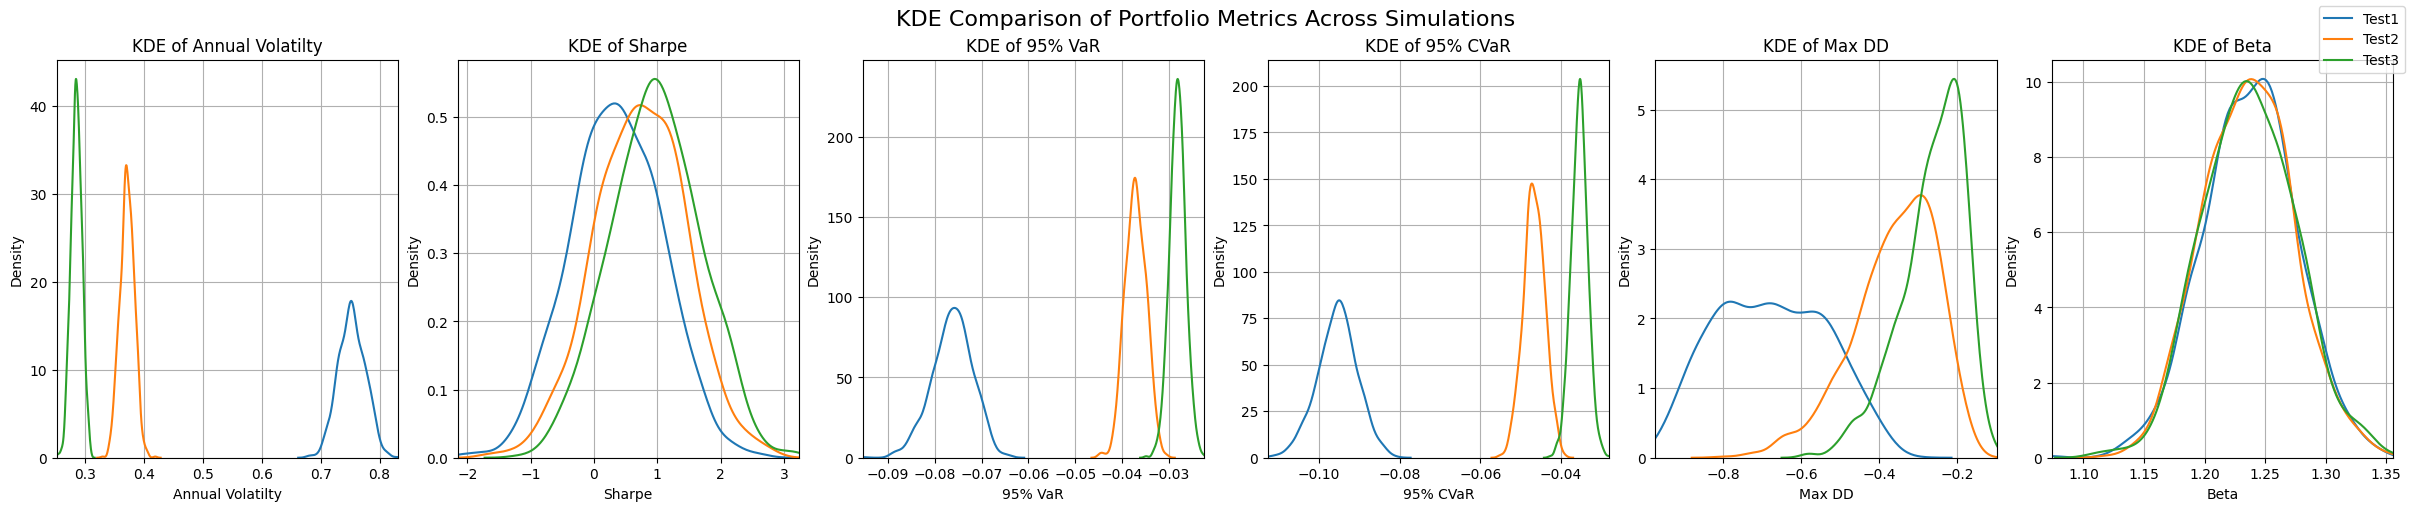

In [63]:
df = test.get_data('5y')
weights = test.get_weights('opt')
test1 = monte_carlo(504,1000, weights, df, 'High', 'Tail Risk') 
test2 = monte_carlo(504,1000, weights, df, 'Low', 'Tail Risk')
test3 = monte_carlo(504,1000, weights, df, 'Medium', 'Moderate')

S = SimulationAnalyzer()
S.add_simulation('Test1', test1)
S.add_simulation('Test2', test2)
S.add_simulation('Test3', test3)
S.all_metrics(weights)
S.visualize_metrics()

In [233]:
#test the simulated max and min sharpe metrics
df = test.get_data('10y')
mc = monte_carlo(504,50,[0.353, 0.0, 0.4469, 0.2001], df, regime="High", level='Moderate')
tickers = list(df.columns) + ['SPY']
sims = len(mc[tickers[0]][0])
all_metrics = []
all_PCR = []
for m in range(sims):
  mth_df = pd.DataFrame({ticker: mc[ticker][:,m] for ticker in tickers})
  metrics = calculate_metrics([0.353, 0.0, 0.4469, 0.2001], mth_df)
  all_metrics.append(metrics[0])
  all_PCR.append(metrics[1])
sharpes = [df.loc["Portfolio", "Sharpe"] for df in all_metrics]
min_idx = np.argmin(sharpes)
max_idx = np.argmax(sharpes)
all_metrics[min_idx].index = ["Worst Portfolio"]
all_metrics[max_idx].index = ["Best Portfolio"]
print(all_metrics[min_idx])
print(all_PCR[min_idx])
print(all_metrics[max_idx])
print(all_PCR[max_idx])

                 Annual Volatilty    Sharpe   95% VaR  95% CVaR    Max DD  \
Worst Portfolio          0.511655 -0.904065 -0.049423 -0.066246 -0.819105   

                     Beta  
Worst Portfolio  1.000064  
       AAPL  BRK-A     JNJ    NVDA
PCR  41.52%  0.00%  22.75%  35.63%
                Annual Volatilty    Sharpe  95% VaR  95% CVaR    Max DD  \
Best Portfolio          0.504639  1.485215 -0.04791 -0.060655 -0.463283   

                    Beta  
Best Portfolio  0.975752  
       AAPL  BRK-A     JNJ    NVDA
PCR  43.10%  0.00%  21.36%  35.44%


In [47]:
def historical(df:pd.DataFrame, crisis:str):
  """
  Returns the prices of your portfolio if during a historical crisis event.
  
  Parameters:
  - df: Dataframe of the historical adjusted close prices of the assets.
  - crisis: String of the event you want to simulate.

    Crisis Options:
    - "DOT-COM" -- The Dot-Com bubble
    - "2008 GFC" -- 2008 Global Financial Crisis
    - "2011 Euro" -- 2011 Eurozone Crisis
    - "COVID" -- COVID-19 Pandemic
    - "2022 Inf" -- 2022 Inflation Crash
  """
  try:
    crisis_periods = {"DOT-COM": ("2000-03-01", "2002-10-01"),
                      "2008 GFC": ("2007-10-01", "2009-03-01"),
                      "2011 Euro": ("2011-07-01", "2011-12-01"),
                      "COVID": ("2020-02-14", "2020-04-15"),
                      "2022 Inf": ("2022-01-01", "2022-10-01")
                      }
    crisis = crisis.strip()
    if crisis not in crisis_periods.keys():
      raise ValueError("Input a valid crisis event.")

    tickers = list(df.columns)
    start_date = pd.to_datetime(crisis_periods[crisis][0])
    end_date = pd.to_datetime(crisis_periods[crisis][1])

    if start_date not in df.index: #check if crisis event does not exist in existing df
      dfcrisis = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=False)["Adj Close"]
    else:
      dfcrisis = df.loc[start_date:end_date]

    for ticker in tickers:
      if dfcrisis[ticker].isna().sum() >= len(dfcrisis[ticker])//3: #checks if any ticker reaches NA threshold
        raise ValueError(f"{ticker} price data does not exist for crisis period.")

    last_price = df.iloc[-1]
    crisisReturns = np.log(dfcrisis/dfcrisis.shift()).dropna()
    cumReturns = (1+crisisReturns).cumprod()
    crisisPrices = last_price.mul(cumReturns)
    return crisisPrices

  except Exception as e:
    print(f" \n Error in historical: {e}")
    return None

In [422]:
df = yf.download(["AAPL", "MSFT", "GOOG", "JNJ", "XOM"], period='10y', auto_adjust=False)["Adj Close"]
hist = historical(df, "COVID")
calculate_metrics([0.0, 0.056, 0.0, 0.444, 0.5], hist)

[*********************100%***********************]  5 of 5 completed


(           Annual Volatilty    Sharpe   95% VaR  95% CVaR    Max DD      Beta
 Portfolio          0.829948 -2.356408 -0.106502 -0.126618 -0.439156  1.097892,
       AAPL   GOOG    JNJ    MSFT     XOM
 PCR  0.00%  4.41%  0.00%  44.53%  49.81%)

In [98]:
class FactorStress:
    def __init__(self, portfolio_df:pd.DataFrame):     
        self.portfolio_df = portfolio_df
        self.log_returns = None
        self.final_factors = None
        self.factors_df = None
        self.rf_df = None
        self.classifications = None
        self.results = None
        
    def process_factors(self, factors:list[str]):
        """
        Input a list of factors that you want to contribute to the classification of each asset.
        Cleans factor CSVs to align with portfolio data and only include desired factors.
        Stores aligned factor data, portfolio log returns, and risk-free rate data in self variables.

        Parameters:
        - factors: A list of strings corresponding to the factors.

        factor options:
        - 'FF3' = Fama-French 3-Research Factors: ['Mkt-RF', 'SMB', 'HML']
        - 'FF5' = Fama-French 5-Research Factors: ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
        - 'Mkt-RF' = Market Returns - Risk-Free-Rate: Market Risk Premium.
        - 'SMB' = Small Minus Big: Returns of small-cap stocks minus large-cap stocks; measures the size anomaly - small-cap tend to outperform.
        - 'HML' = High Minus Low: Returns of high B/M (value) stocks minus low B/M (growth) stocks; measures the value anomaly - value stocks tend to outperform.
        - 'RMW' = Robust Minus Weak: Returns of firms with robust profitability minus those with weak profitability; measures profitability factor - more robust firms tend to earn higher returns.
        - 'CMA' = Conservative Minus Aggressive: Returns of firms with conservative investment minus aggressive policies; captures investment factor - conservative tend to perform better.
        - 'Mom' = Momentum: Returns of stocks with high prior returns minus those with low prior returns; captures the momentum effect where past winners tend to continue outperforming in the short term.

        """
        try:
            factor_map = {
                'FF3': ['Mkt-RF', 'SMB', 'HML'],
                'FF5': ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
            }

            extended = []
            for factor in factors:
                if factor in factor_map.keys():
                    extended.extend(factor_map[factor])
                else:
                    extended.append(factor)
            self.final_factors = list(set(extended))

            #Read and clean factor CSVs
            FFdf = pd.read_csv('../data/F-F_Research_Data_5_Factors_2x3_daily.csv', skiprows=3, index_col=0).iloc[:-1]
            FFdf.index = pd.to_datetime(FFdf.index)
            MOMdf = pd.read_csv('../data/F-F_Momentum_Factor_daily.csv', skiprows=13, index_col=0).iloc[:-1]
            MOMdf.index = pd.to_datetime(MOMdf.index)

            #Align both factor CSVs and only grab necessary factors
            factor_align = MOMdf.index.intersection(FFdf.index)
            FFdf = FFdf.loc[factor_align]
            MOMdf = MOMdf.loc[factor_align]
            full_factors = pd.concat([FFdf, MOMdf], axis=1)
            rf = full_factors['RF'].copy()
            full_factors = full_factors[self.final_factors]
        
            #Align historical asset returns with joint factor df
            log_returns = np.log(self.portfolio_df/self.portfolio_df.shift()).dropna()
            aligned_index = log_returns.index.intersection(full_factors.index) 
            self.log_returns = log_returns.loc[aligned_index]
            self.factors_df = full_factors.loc[aligned_index]/100
            self.rf_df = rf.loc[aligned_index]/100

            return self.factors_df

        except Exception as e:
            print(f"Error in clean_data: {e}")
            return None


    def classify_factors(self):
        """ 
        Conducts classification of assets through OLS based on the factors desired.
        """
        try:
            #Fit OLS on each ticker and store neccesary values
            tickers = list(self.portfolio_df.columns)
            self.results = {}
            classifications = {ticker: [] for ticker in tickers}
            for ticker in tickers:
                excess_returns = self.log_returns[ticker] - self.rf_df
                X = sm.add_constant(self.factors_df)
                y = excess_returns
                
                model = sm.OLS(y, X).fit()
                self.results[ticker] = {
                    'alpha': model.params['const'],
                    'betas': model.params.drop('const').to_dict(),
                    'r-squared': model.rsquared
                }
                #Stock Classification
                betas = self.results[ticker]['betas']

                for factor in self.final_factors:
                    #Mkt-RF
                    if factor == 'Mkt-RF': 
                        if betas[factor] > 1.1:
                            classifications[ticker].append('High-Beta')
                        elif betas[factor] < 0.9:
                            classifications[ticker].append('Low-Beta')
                        else:
                            classifications[ticker].append('Normal-Beta')

                    #SMB
                    if factor == 'SMB':
                        if betas[factor] > 0.3:
                            classifications[ticker].append('Small-Cap')
                        elif betas[factor] < -0.3:
                            classifications[ticker].append('Large-Cap')
                        else:
                            classifications[ticker].append('Mid-Cap')

                    #HML
                    if factor == 'HML':
                        if betas[factor] > 0.3:
                            classifications[ticker].append('Value')
                        elif betas[factor] < -0.3:
                            classifications[ticker].append('Growth')
                        else:
                            classifications[ticker].append('Blend')

                    #RMW
                    if factor == 'RMW': 
                        if betas[factor] > 0.2:
                            classifications[ticker].append("High-Quality")
                        elif betas[factor] < -0.2:
                            classifications[ticker].append('Low-Quality')
                        else:
                            classifications[ticker].append('Normal-Quality')

                    #CMA
                    if factor == 'CMA': 
                        if betas[factor] > 0.2:
                            classifications[ticker].append('Conservative')
                        elif betas[factor] < -0.2:
                            classifications[ticker].append('Agressive')
                        else:
                            classifications[ticker].append('Moderate')

                    #MOM
                    if factor == 'Mom':
                        if betas[factor] > 0.1:
                            classifications[ticker].append('High-Momentum')
                        elif betas[factor] < -0.1:
                            classifications[ticker].append('Low-Momentum')
                        else:
                            classifications[ticker].append('Mid-Momentum')

            classifications_df = pd.DataFrame.from_dict(data=classifications, orient='index', columns=self.final_factors)
            self.classifications = classifications_df
            return classifications_df
        
        except Exception as e:
            print(f"Error in classify_factors: {e}")
            return None
    
    def stress_means(self, shocks:dict):
        """ 
        Returns a list of the stressed expected returns for each asset based on the factors shocked.

        Parameters:
        - shocks: A dictionary of factor, shock pairs denoting the percentage increase or decrease you want each factor to be shocked by.
                  = Example: {'SMB': 0.2} shocks the size premium by 20%; tests how your portfolio performs when small-cap returns surge.
                  
                  = If 'FF3' or 'FF5' is entered in factors, enter a list within shocks that corresponds to each of factors or enter a float to apply a unform shock to all factors within 'FF3' or 'FF5'. 
                  = Example: {'FF3':[0.1, 0.2, 0.3], 'Mom':0.4]} or {'FF3':0.1, 'Mom':0.4} to apply uniform shock to 'FF3'
        """
        try:
            for factor in shocks.keys():
                if factor not in (self.final_factors + ['FF3','FF5']):
                    raise ValueError("You cant not shock a factor that was not included in the multi-factor-model.")
                
            #Standardize shock dict
            for factor in self.final_factors:
                if factor not in shocks.keys():
                    shocks[factor] = 0

            #Handle 'FF3' and 'FF5' shocks
            FF3_check = FF5_check = False
            if 'FF3' in shocks.keys():
                FF3_check = True
                FF3_value = shocks.pop('FF3')

                if isinstance(FF3_value, list): #Unique shocks per factor in 'FF3'
                    if len(FF3_value) == 3:
                        shocks.update({
                            'Mkt-RF': FF3_value[0],
                            'SMB': FF3_value[1],
                            'HML': FF3_value[2]
                            })
                    else:
                        raise ValueError("Invalid shock length for 'FF3'. Either input a float for a uniform shock or a list of independent shocks for each factor.")
                else: #Uniform shock to all factors in 'FF3'
                    shocks.update({
                        'Mkt-RF': FF3_value,
                        'SMB': FF3_value,
                        'HML': FF3_value
                        })
            if 'FF5' in shocks.keys():
                FF5_check = True
                FF5_value = shocks.pop('FF5')

                if isinstance(FF5_value, list): #Unique shocks per factor in 'FF5'
                    if len(FF5_value) == 5:
                        shocks.update({
                            'Mkt-RF': FF5_value[0],
                            'SMB': FF5_value[1],
                            'HML': FF5_value[2],
                            'RMW': FF5_value[3],
                            'CMA': FF5_value[4]
                        })
                    else:
                        raise ValueError("Invalid shock length for 'FF5'. Either input a float for a uniform shock or a list of independent shocks for each factor.")
                else: #Uniform shock to all factors in 'FF5'
                   shocks.update({
                        'Mkt-RF': FF5_value,
                        'SMB': FF5_value,
                        'HML': FF5_value,
                        'RMW': FF5_value,
                        'CMA': FF5_value
                        })
            if FF3_check and FF5_check:
                print("Warning: Both 'FF3' and 'FF5' have been inserted in the shocks dictionary. FF5 factors have overwritten overlapping FF3 factors.")
                print(shocks)

            #Compute stressed mean returns
            stressed_means = {}
            factor_means = self.factors_df.mean()
            tickers = list(self.portfolio_df.columns)
            for ticker in tickers:
                alpha = self.results[ticker]['alpha']
                betas = self.results[ticker]['betas']
                stressed_mean = alpha
                for factor in self.final_factors:
                    stressed_mean += betas[factor]*factor_means[factor]*(1+shocks[factor])
                stressed_means[ticker] = stressed_mean
            stressed_means['SPY'] = 0.0
            stressed_means_list = list(map(float, list(stressed_means.values())))

            return stressed_means_list         

        except Exception as e:
            print(f"Error in stress_means: {e}")
            return None
        

In [99]:
f = FactorStress(df)
f.process_factors(['FF5', 'Mom'])
f.classify_factors()

,HML,RMW,CMA,Mom,Mkt-RF,SMB
AAPL,Growth,High-Quality,Conservative,Mid-Momentum,High-Beta,Mid-Cap
BRK-A,Value,Normal-Quality,Moderate,Mid-Momentum,Low-Beta,Mid-Cap
JNJ,Blend,Normal-Quality,Moderate,Low-Momentum,Low-Beta,Mid-Cap
NVDA,Growth,Normal-Quality,Moderate,High-Momentum,High-Beta,Large-Cap


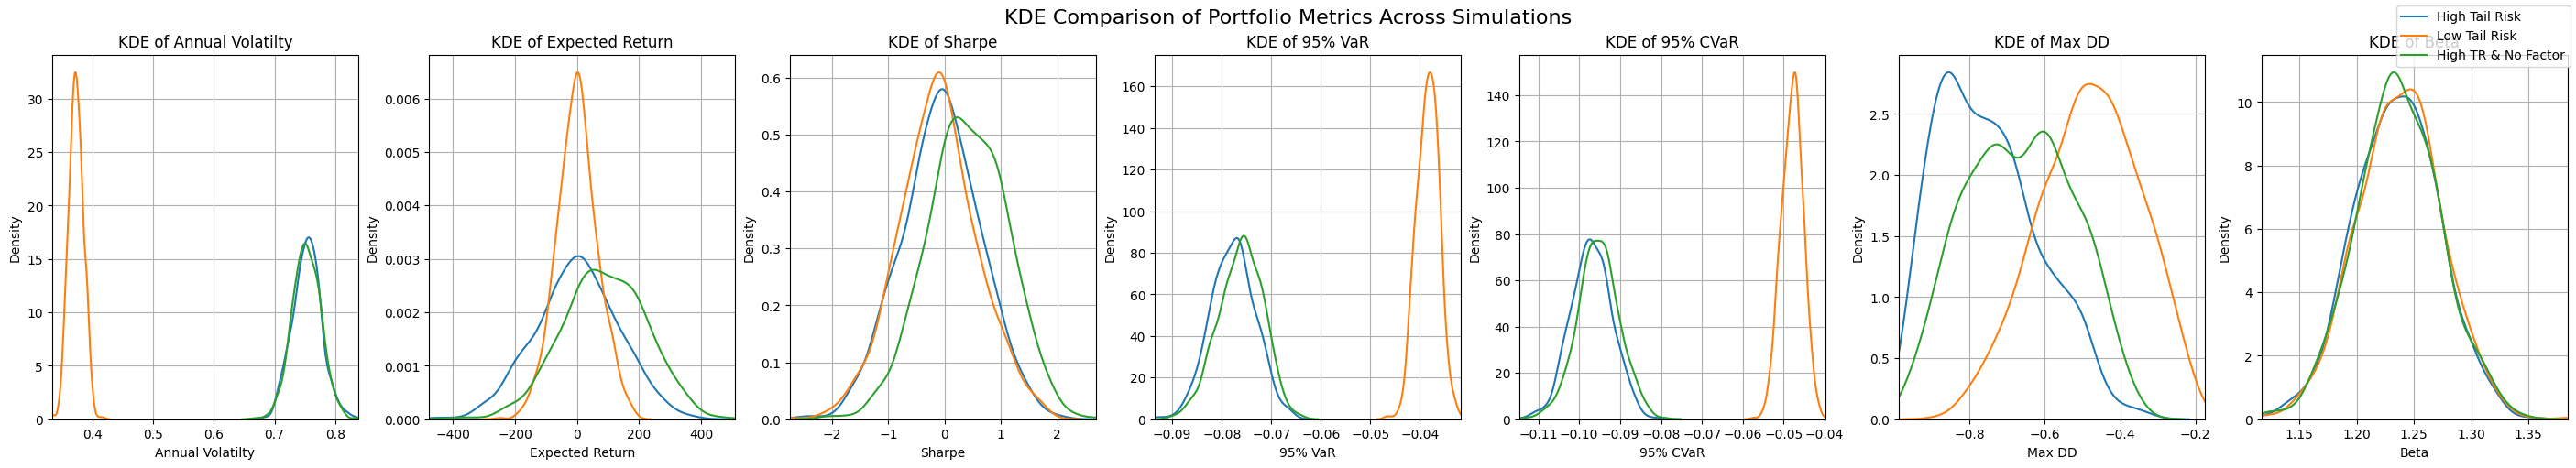

In [76]:
df = test.get_data('5y')
weights = test.get_weights('opt')
f = FactorStress(df)
f.process_factors(['FF5'])
f.classify_factors()
smeans = f.stress_means({'FF3': -2})

test1 = monte_carlo(504,1000, weights, df, 'High', 'Tail Risk', smeans) 
test2 = monte_carlo(504,1000, weights, df, 'Low', 'Tail Risk', smeans)
test3 = monte_carlo(504,1000, weights, df, 'High', 'Tail Risk') 

S = SimulationAnalyzer()
S.add_simulation('High Tail Risk', test1)
S.add_simulation('Low Tail Risk', test2)
S.add_simulation('High TR & No Factor', test3)
S.all_metrics(weights)
S.visualize_metrics()

In [ ]:
weights = [0.25, 0.25, 0.25, 0.25]
strw = [str(weight) for weight in weights]
", ".join(strw)

'0.25, 0.25, 0.25, 0.25'